In [252]:
%load_ext iminizinc

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
from ipywidgets import *
from IPython.display import display
import IPython
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from datetime import datetime
import talib
import pandas_ta as ta
# from talib.abstract import *
from math import *
from collections import OrderedDict
# import vectorbt as vbt    
import json
from decimal import *
getcontext().prec = 6
import seaborn as sns

import mplfinance as mpf

matplotlib.rcParams.update({'font.size': 5, 'lines.linewidth': 0.5, 'figure.dpi': 300})
plt.rcParams['lines.linewidth'] = 0.5 


In [82]:
odf = pd.read_json(r'../freq-user-data/data/binance/BTC_USDT-1d.json').dropna()
odf.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']

odf['date'] = pd.to_datetime(odf['timestamp'], unit='ms', utc=False)
# df.index = df['time']
# df.set_index('time', drop=True, inplace=True)
odf['idate'] = odf.date.dt.strftime('%Y%m%d')
odf.set_index(pd.DatetimeIndex(odf["date"]), inplace=True, drop=True)
# df = df[['time', 'symbol', 'source', 'resolution', 'open', 'high', 'low', 'close', 'volume']]
# df.to_csv (r'./data/binance/BTC_USDT-5m.csv', index = None)
# df.set_index('time')
odf = odf.sort_index()
odf

,timestamp,open,high,low,close,volume,date,idate
date,,,,,,,,
2021-01-01,1609459200000,28923.63,29600.00,28624.57,29331.69,54182.925011,2021-01-01,20210101
2021-01-02,1609545600000,29331.70,33300.00,28946.53,32178.33,129993.873362,2021-01-02,20210102
2021-01-03,1609632000000,32176.45,34778.11,31962.99,33000.05,120957.566750,2021-01-03,20210103
2021-01-04,1609718400000,33000.05,33600.00,28130.00,31988.71,140899.885690,2021-01-04,20210104
2021-01-05,1609804800000,31989.75,34360.00,29900.00,33949.53,116049.997038,2021-01-05,20210105
...,...,...,...,...,...,...,...,...
2023-04-17,1681689600000,30304.66,30316.06,29240.65,29430.27,56441.811270,2023-04-17,20230417
2023-04-18,1681776000000,29430.27,30485.00,29096.78,30380.01,62004.894340,2023-04-18,20230418
2023-04-19,1681862400000,30380.01,30413.53,28520.00,28797.10,86575.486560,2023-04-19,20230419


In [102]:
list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
def PT(Q):
    d = None
    P, T, S, a, b, i, d = set(), set(), set(), 0, 0, 0, None
    for i in range(len(Q)):
        if d is None:
            if Q[a] >= Q[i]:
                d = 1 
            elif Q[i] >= Q[b]:
                d = -1
            if Q[a] < Q[i]:
                a = i
            elif Q[i] > Q[b]:
                b = i
            S = {i}
            
        elif d == 1:
            if Q[a] < Q[i]:
                S,a = {i},i
            elif Q[a] == Q[i]:
                S.add(i)
            elif Q[a] > Q[i]:
                P = P | S
                S,b,d = {i}, i, -1
        
        elif d == -1:
            if Q[i] < Q[b]:
                S,b = {i}, i
            elif Q[i] == Q[b]:
                S.add(i)
            elif Q[i] >= Q[b]:
                T = T | S
                S,a,d = {i}, i, 1
                  
    return sorted(P),sorted(T)

# PT(df.close)

peaks, troughs = PT(df.close)
# (list(peaks)).sort()
df.index[peaks]
# ax1.scatter(df.index[[peaks]], df.close[[peaks]])

### Find all the peaks and troughs

In [231]:

df = odf['2021-06-02':'2022-08-03']
kl_n = len(df)
pktr_n = floor(len(df) / 7)
kl_close = df.close.astype(int).tolist()

In [240]:
%%minizinc -m bind

array[int] of int: kl_close;

int: kl_n;
set of int: KLN = 1..kl_n;
set of int: KLN0 = 0..kl_n;
int: pktr_n;
set of int: PKTR = 1..pktr_n;

array[PKTR] of var KLN0: apktr;

var PKTR: npktr;

constraint apktr[npktr] = 1;
constraint apktr[pktr_n] = kl_n;
constraint forall(j in 1..npktr-1)(apktr[j] = 0);

include "increasing.mzn";
constraint increasing(apktr);

constraint forall(i in npktr..pktr_n-1)(
    let { var KLN: idn = if kl_close[apktr[i]]>kl_close[apktr[i+1]] then i+1 else i endif, 
          var KLN: iup = if idn = i then i+1 else i endif} in
          forall(j in apktr[i]+1..apktr[i+1]-1)(kl_close[j] >= kl_close[apktr[idn]] /\ kl_close[j] <= kl_close[apktr[iup]] )
);

constraint forall(i in npktr..pktr_n-2)(
    kl_close[apktr[i]] >= kl_close[apktr[i+1]] /\ kl_close[apktr[i+1]] <= kl_close[apktr[i+2]]
    \/ kl_close[apktr[i]] <= kl_close[apktr[i+1]] /\ kl_close[apktr[i+1]] >= kl_close[apktr[i+2]]
    );

include "alldifferent.mzn";
constraint all_different_except_0(apktr);

solve maximize npktr;

In [248]:
apktrs = list(filter(lambda x: x > 0, apktr))
# apktrs = [160, 382, 422, 428]
apktrs = np.array(apktrs) -1 
apktrs

array([159, 381, 421, 427])

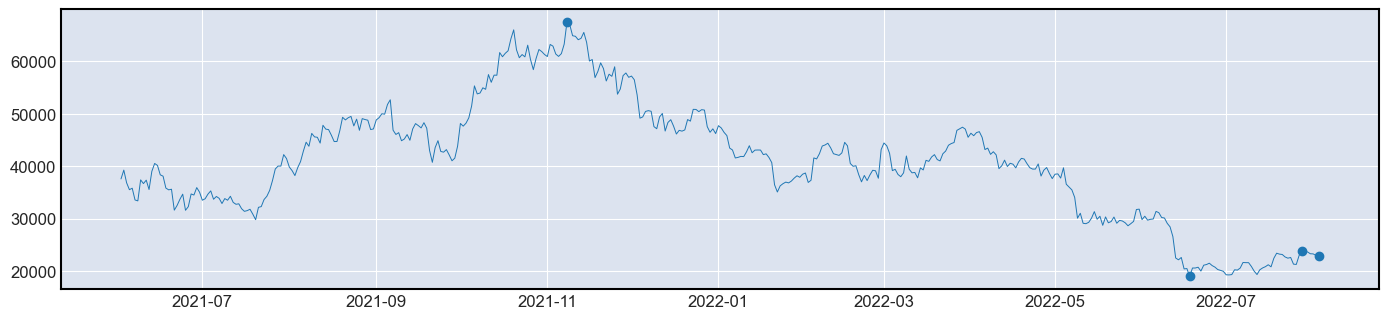

In [249]:
fig = mpf.figure(figsize=(17,8))
ax1 = fig.add_subplot(2,1,1)

ax1.plot(df.close, lw=0.7)
ax1.scatter(df.index[apktrs], df.close[apktrs])


### Find last n peaks

In [250]:
df = odf['2021-06-02':'2022-08-03']
kl_n = len(df)
pktr_n = 4 # Last 3 peaks inc last 
kl_close = df.close.astype(int).tolist()

In [251]:
%%minizinc -m bind

array[int] of int: kl_close;

int: kl_n;
set of int: KLN = 1..kl_n;
set of int: KLN0 = 0..kl_n;
int: pktr_n;
set of int: PKTR = 1..pktr_n;

array[PKTR] of var KLN0: apktr;

var PKTR: npktr;

constraint apktr[npktr] >= 1;
constraint apktr[pktr_n] = kl_n;
constraint forall(j in 1..npktr-1)(apktr[j] = 0);

include "increasing.mzn";
constraint increasing(apktr);

constraint forall(i in npktr..pktr_n-1)(
    let { var KLN: idn = if kl_close[apktr[i]]>kl_close[apktr[i+1]] then i+1 else i endif, 
          var KLN: iup = if idn = i then i+1 else i endif} in
          forall(j in apktr[i]+1..apktr[i+1]-1)(kl_close[j] >= kl_close[apktr[idn]] /\ kl_close[j] <= kl_close[apktr[iup]] )
);

constraint forall(i in npktr..pktr_n-2)(
    kl_close[apktr[i]] >= kl_close[apktr[i+1]] /\ kl_close[apktr[i+1]] <= kl_close[apktr[i+2]]
    \/ kl_close[apktr[i]] <= kl_close[apktr[i+1]] /\ kl_close[apktr[i+1]] >= kl_close[apktr[i+2]]
    );

include "alldifferent.mzn";
constraint all_different_except_0(apktr);

solve minimize npktr;


### Scipy's algo for peaks

In [ ]:
from scipy import signal

peaks = signal.find_peaks(df.close, height=None, threshold=None, distance=7, prominence=None, width=None, wlen=None, rel_height=0.5, plateau_size=None)
peaks[0]
df.index[peaks[0]]

### Export data to MiniZinc dzn

In [235]:

with open('klines.dzn', 'w+') as f:
    f.write(f'kl_n = {len(df)};\n')
    f.write(f'pktr_n = {floor(len(df) / 5)};\n')
    for k in ['open', 'high', 'low', 'close']:
        f.write(f'kl_{k} = [' + ', '.join(df[k].astype(int).astype(str)) + '];\n')
        f.flush()

12

13

3008

3008

3007

3009